In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

## Задача 7

- Загрузите данные из файла, установите колонку Date как индекс, отобразите график временного ряда Value.

In [ ]:
df = pd.read_csv('../data/05-2-sarima-data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

ts = df['Value']

df.sample(5)


,Value
Date,
2019-12-31,58.259665
2011-07-31,4.459880
2014-05-31,31.275644
2012-05-31,19.657061
2012-09-30,7.272260


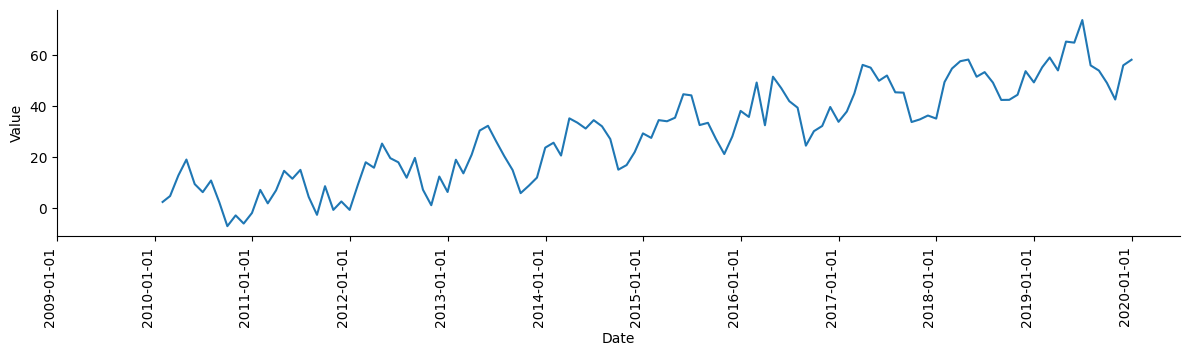

In [6]:
# Тренд есть, сезонность есть, выбросов нет
g = sns.relplot(x=df.index, y=df['Value'], kind='line', height=3, aspect=4)
g.set_xticklabels(rotation=90, horizontalalignment="right", step=1);

- Проверьте стационарность ряда с помощью ADF-теста. Выведите ADF Statistic и p-value.

In [7]:
def test_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    if result[1] > 0.05:
        print("Ряд нестационарный")
    else:
        print("Ряд стационарный")

test_stationarity(ts)

ADF Statistic: 0.754749485280712
p-value: 0.9908694886838924
Critical Values: {'1%': np.float64(-3.4936021509366793), '5%': np.float64(-2.8892174239808703), '10%': np.float64(-2.58153320754717)}
Ряд нестационарный


- Сделайте дифференцирование: обычное (lag=1) и сезонное (lag=12). Постройте график после сезонного дифференцирования.

In [8]:
ts_diff = ts.diff(1).diff(12).dropna()
test_stationarity(ts_diff)

ADF Statistic: -4.106035153275883
p-value: 0.0009465152306920579
Critical Values: {'1%': np.float64(-3.502704609582561), '5%': np.float64(-2.8931578098779522), '10%': np.float64(-2.583636712914788)}
Ряд стационарный


- Постройте графики ACF и PACF для преобразованного ряда.

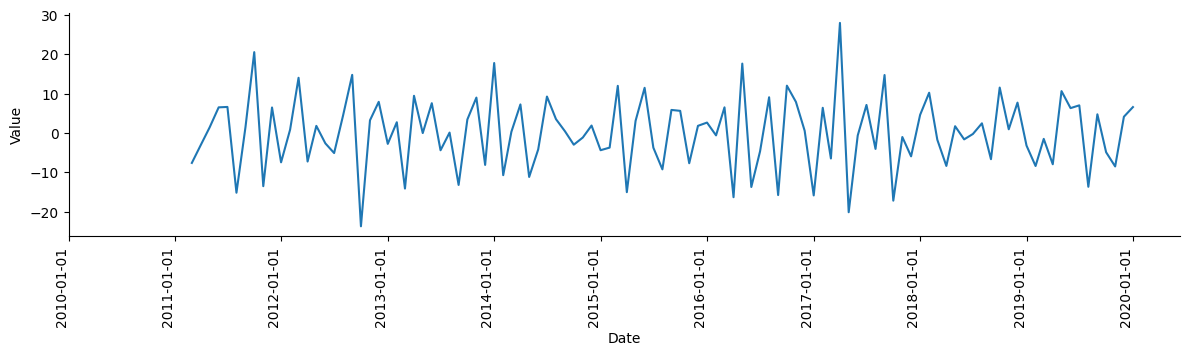

In [9]:
ts_diff_df = ts_diff.reset_index()
ts_diff_df.set_index('Date', inplace=True)

g = sns.relplot(x=ts_diff_df.index, y=ts_diff_df['Value'], kind='line', height=3, aspect=4)
g.set_xticklabels(rotation=90, horizontalalignment="right", step=1);

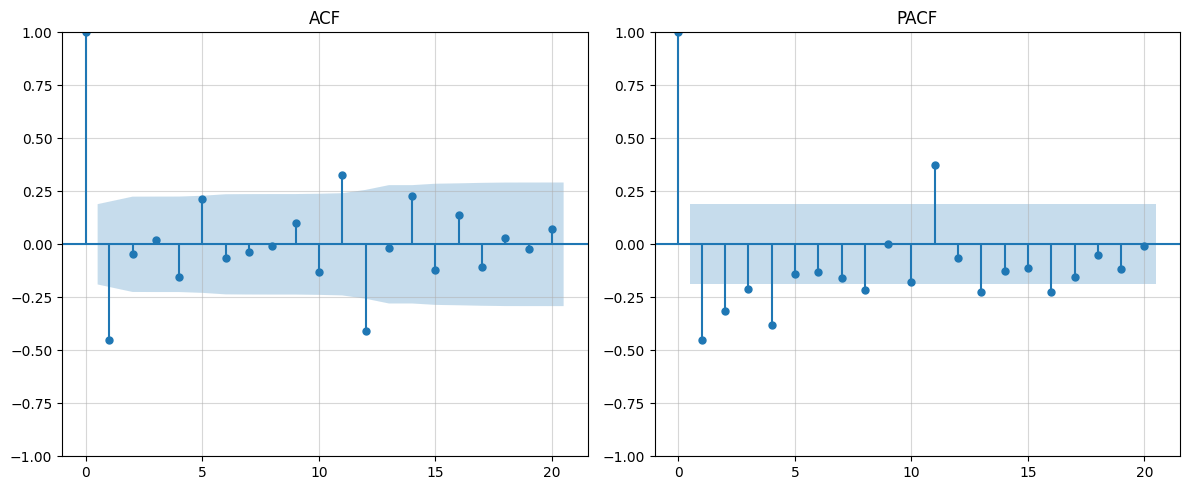

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(ts_diff, ax=ax1, lags=20)
ax1.grid(True, alpha=0.5)
ax1.set_title("ACF")

plot_pacf(ts_diff, ax=ax2, lags=20, method='ywm')
ax2.grid(True, alpha=0.5)
ax2.set_title("PACF")

plt.tight_layout()
plt.show()

- Разделите данные на обучающую (80%) и тестовую (20%) части.

In [11]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

- Обучите SARIMA-модель с параметрами на обучающей выборке.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
print(model_fit.summary())

/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Users/skv/PycharmProjects/study-timeseries-analysis-forecasting/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83856D+00    |proj g|=  8.30101D-02

At iterate    5    f=  2.72006D+00    |proj g|=  3.83662D-02

At iterate   10    f=  2.71207D+00    |proj g|=  2.98117D-03

At iterate   15    f=  2.71072D+00    |proj g|=  1.19397D-03

At iterate   20    f=  2.71058D+00    |proj g|=  3.50522D-04

At iterate   25    f=  2.71056D+00    |proj g|=  1.29057D-04

At iterate   30    f=  2.71055D+00    |proj g|=  2.32619D-04

At iterate   35    f=  2.71055D+00    |proj g|=  6.12975D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

- Сделайте прогноз на длину тестовой выборки и постройте график train, test и forecast.

In [13]:
forecast = model_fit.forecast(steps=len(test))
forecast.index = test.index

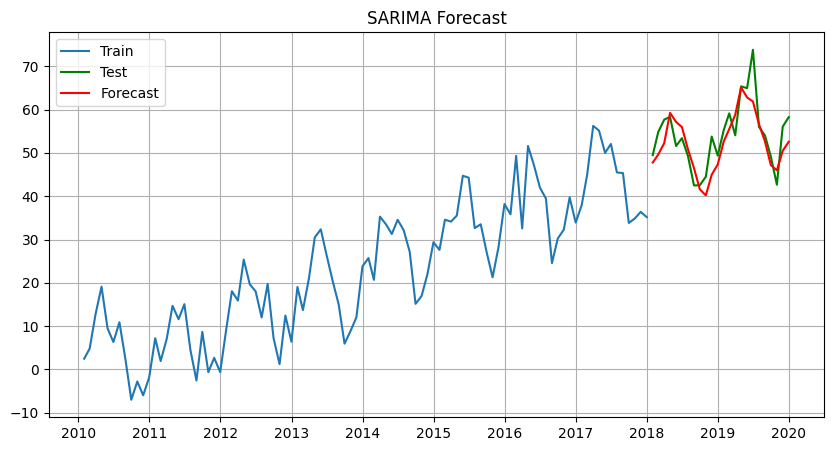

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='green')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.legend()
plt.grid()
plt.show()

- Вычислите MAE, MSE, RMSE и MAPE между прогнозом и тестом.

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, forecast)
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test, forecast)

print("MAE:", round(mae, 4))
print("MSE:", round(mse, 4))
print("RMSE:", round(rmse, 4))
print("MAPE:", round(mape * 100, 2), '%')

MAE: 3.623
MSE: 20.3425
RMSE: 4.5103
MAPE: 6.63 %
